# Category continuity understanding through synthetic data examples

This notebook demonstrates category continuity properties using synthetic data examples. For a better experience, these examples are made interactive, allowing you to experiment with simulation and metric parameters using [IPyWidgets](https://ipywidgets.readthedocs.io/en/stable/). If you prefer a non-interactive version or for compatibility reasons, please set the variable `is_interactive` below to `False`.

In [14]:
is_interactive = True

## Category continuity definition

Category continuity is a metric proposed as a slight variation of the NN-norm described in [Pauwel et al. paper](https://www.sciencedirect.com/science/article/pii/S1077314299907634).
This metric measures local continuity within a point cloud in terms of a category, which is a label of the samples. The computation follows this algorithm:

**Input:** 
- N points $(x_i) \in \mathbb{R}^{d \times N}$ and their category labels $(l_i) \in  \mathbb{R}^N$
- Number of neighbors K

**Algorithm:**
For each point $x_i$ and its category label $l_i$
1. Compute $\mathcal{K}$ the set of indices of its K nearest neighbors
1. $s_i \Leftarrow |\{k\in \mathcal{K} \text{ such that } l_k = l_i\}| / K$ (ratio of neighbors with the same label as $x_i$)

**Output:**

Average continuity per point:
$
\frac{1}{N} \sum_{i=1}^Ns_i
$



## Useful imports and functions

In [7]:
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_moons
from ipywidgets import interact, fixed

# The following line loads the module repository is not added to your python path
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
from Utils.metrics import category_continuity

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def plot_x_score(ax, x, labels, scores, score_label):
    """
    Plot X 2D data on the ax, with color corresponding to the scores and marker form corresponding to labels.
    Arguments:
    ----------
    ax: matplotlib.pyplot.Axes
    The ax to support the plot

    x: numpy.array
    An array of dimension (N, 2) of the data point cloud to be plot

    labels: numpy.array
    Labels of the point, shape (N)

    scores: numpy.array
    Scores of the point, shape (N)

    score_label: str
    Name of the score for colorbar legend

    """
    marker = {0: "o", 1: "v", 2:"s", 3: "P", 4: "d", 5:".", 6:"*"}
    cmap_score = cm.plasma_r
    for l in np.unique(labels):
        ax.scatter(x[np.where(labels == l), 0], x[np.where(labels == l), 1], 
                        c=scores[np.where(labels == l)], 
                        marker=marker[l], 
                        cmap=cmap_score,
                        vmin = 0.,
                        vmax = 1.,
                        alpha = 0.6)
    plt.colorbar(cm.ScalarMappable(cmap=cmap_score), ax = ax, label = score_label)

def generate_spiral_data(N, radius = 5, phase = 0, sigma= 1.):
    """
    Generate N points from a noisy spiral from center (0, 0) to radius with a phase.
    The code was inspired from tensorflow playground: https://github.com/tensorflow/playground/blob/master/src/dataset.ts#L160
    Arguments:
    ----------
    N: int
    Number of point in the spirale

    radius: float or int
    Radius of the spirale

    phase: float or int
    Phase of the spirale, betwwen 0 and pi
    
    sigma: float
    Noise level
    """
    rs = np.array([i / N * radius for i in range(N)])
    thetas = np.array([1.75 * i / N * 2 * np.pi + phase for i in range(N)])
    X = np.vstack([rs * np.sin(thetas) + np.random.rand(N) * sigma, rs * np.cos(thetas) + np.random.rand(N) * sigma]).T
    return X

def generate_2D_ring_data(N, radius_min, radius_max):
    """
    Generate N points uniformly distributed in a ring between radius_min and radius_max.
    Arguments:
    ----------
    N: int
    Number of point in the spirale

    radius_min: float or int
    Minimal radius of the ring

    radius_max: float or int
    Maximal radius of the ring
    """
    rs = np.random.rand(N) * (radius_max - radius_min) + radius_min
    angles = np.random.rand(N) * 2 * np.pi
    return np.vstack([rs * np.cos(angles), rs * np.sin(angles)]).T

def get_ring_label_noisy(x, min_radius = None, max_radius = None, noise_level = 0.):
    """
    Return noisy labels for a pointcloud of a ring: 0 for not in the ring, 1 for in the ring.
    Arguments:
    ----------
    x: numpy.array
    An array of dimension (N, 2) of the data

    min_radius: float or int
    Minimal radius of the ring

    max_radius: float or int
    Maximal radius of the ring

    noise_level: float
    Scaling coefficient of the noise between 0 and 1 applied to the data before labeling 
    """
    x_noisy = x + (np.random.rand(**x.shape) - 0.5) * np.mean(np.linalg.norm(x, axis = 1)) * noise_level
    labels = np.ones(x_noisy.shape[0]) * True
    if min_radius is not None:
        labels = labels and (x_noisy > min_radius)
    if max_radius is not None:
        labels = labels and (x_noisy < max_radius)
    return 1. * labels



## Implementation demonstration: basic example with 6 points

If plot does not show correctly, please switch is_interactive to False.


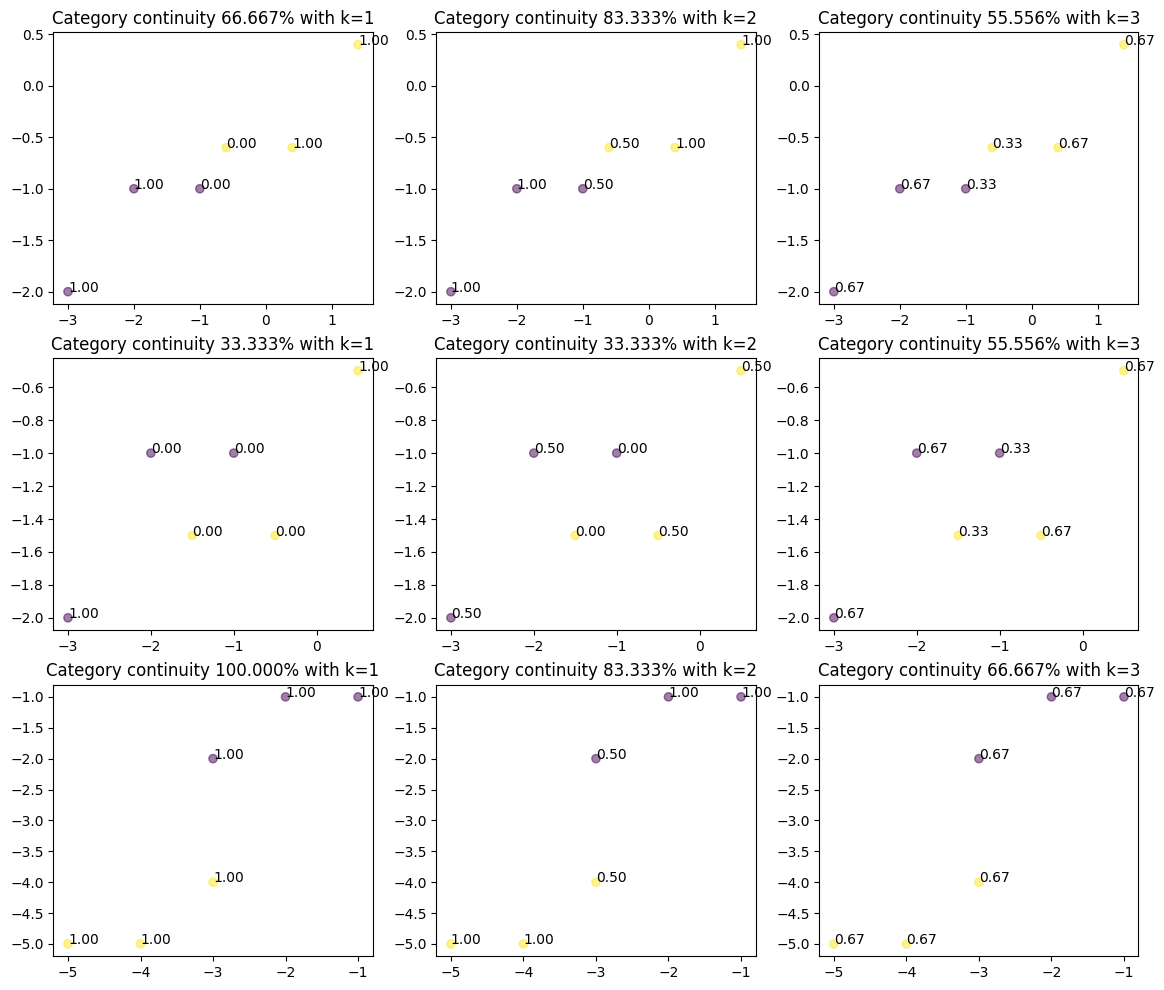

In [24]:
def plot_3points(ax, deplacement = 2.1, k=3):
    """
    Plot six points in two categories on an ax, with a degree of liberty.
    Arguments:
    ----------
    ax: matplotlib.pyplot.Axes
    The ax to support the plot

    deplacement: float
    An empirical degree of liberty to move some points

    k: int
    Category continuity parameter for the number of neighbors
    """
    # Points and labels
    X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]], dtype=np.float32)
    X[3:, :] = X[3:, :] - deplacement
    y = np.array([1, 1, 1, 2, 2, 2])

    #Category continuity
    args = {'k': k, 'aggregation': 'total_mean', 'sigma' : None}
    s, x_scores = category_continuity(X, y, **args)

    #Plot
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)
    for i, x in enumerate(X):
        ax.annotate(f"{x_scores[i]:.2f}", (x[0], x[1]))
    ax.set_title(f"Category continuity {s:.3%} with k={args['k']}")

def single_plot_3_points(deplacement = 2.1, k=3):
    """
    Plot three point on a single image
    Arguments:
    ----------
    deplacement: float
    An empirical degree of liberty to move some points

    k: int
    Category continuity parameter for the number of neighbors
    """
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    plot_3points(ax, deplacement, k)
    plt.show()

print("If plot does not show correctly, please switch is_interactive to False.")
if is_interactive:
    interact(single_plot_3_points, deplacement = 2.1, k=(1, 5, 1))
else:
    depls = [1.6, 2.5, 6.]
    ks = [1, 2, 3]
    fig, axs = plt.subplots(len(depls), len(ks), figsize=(2 + 4 * len(depls), 4 * len(ks)))
    for i, depl in enumerate(depls):
        for j, k in enumerate(ks):
            plot_3points(axs[i, j], depl, k)
    plt.show()
plt.show()

> For low values of `K`, each point score is highly dependant of its closest neighbors. 
> For values of `K` higher than the number of samples $N_c$ in the category, the highest score achievable is only $N_c/K$. 

## Properties illustrations
>**1. Category continuity does not penalize the number of clusters by class or cluster shapes, contrary to silhouette score applied to a category.**

This property is illustrated with four Gaussian clusters labeled in three or four categories. Category continuity is not changed whereas the silhouette score drops. Category contrinuiy has reached its maximal value because clusters are highly separable: the closest neighbors are in the same cluster. An example with categories organized in spirales, and not in ball-shaped clusters, demonstrates a failure case of the silhouette score to quantify the cluster separability. Category continuity score is low in the center zone where clusters are overlapping, and at the frontier between spirales.

The spirale example is inspired from [TensorFlow playground](https://playground.tensorflow.org/) and [its code](https://github.com/tensorflow/playground/blob/master/src/dataset.ts#L160).

In [26]:
from permetrics import ClusteringMetric

def ex_cluster_penalisation(k=10, N = 300, sigma = 1.):
    """
    Plot three plots for silhouette score and category continuity comparison
    Arguments:
    ----------
    k: int
    Category continuity parameter for the number of neighbors

    N: int
    Number of points

    sigma: float
    Standard deviation of the generative Gaussian distribution 
    """
    # Gaussian examples
    ## Generate
    ms = [np.array([-5, 5]), np.array([5, -5]), np.array([5, 5]), np.array([-5, -5])]
    sigmas = [np.eye(2) * sigma, np.eye(2) * sigma, np.eye(2) * sigma, np.eye(2) * sigma]    
    X = np.concatenate([np.random.multivariate_normal(m, s, N) for m, s in zip(ms, sigmas)])
    ys = [
        np.array([0] * N + [1] * N + [2] * N + [3] * N),
        np.array([0] * N + [1] * N + [2] * N + [2] * N)
    ]
    fig, axs = plt.subplots(2, 4, figsize = (4 * 4 + 2, 4 * 2))
    for i, y in enumerate(ys):
        ## Scores
        args = {'k': k, 'aggregation': 'total_mean', 'sigma' : None}
        s, x_score = category_continuity(X, y, **args)
        s_ss = silhouette_score(X, y, metric="euclidean")
        cm = ClusteringMetric(X=X, y_pred=y)
        s_inv_dbcv = 1 - cm.density_based_clustering_validation_index()
    
        ## Plot
        axs[0, i].scatter(X[:, 0], X[:, 1], c=y, alpha = 0.6)
        axs[0, i].set_title(f"Category continuity (k={args['k']}) {s:.3%}\nSilhouette score {s_ss:.3%}\nDBCV {s_inv_dbcv:.3%}", color="red")
        plot_x_score(axs[1, i], X, y, x_score, score_label="Category continuity")
    
    # Spirale example
    ## Generate
    X_sp1 = generate_spiral_data(N, 5, 0, sigma)
    X_sp2 = generate_spiral_data(N, 5, np.pi, sigma)
    X = np.concatenate((X_sp1, X_sp2))
    y = np.array([0] * N + [1] * N)
    ## Scores
    args = {'k': k, 'aggregation': 'total_mean', 'sigma' : None}
    s, x_score = category_continuity(X, y, **args)
    s_ss = silhouette_score(X, y, metric="euclidean")
    cm = ClusteringMetric(X=X, y_pred=y)
    s_inv_dbcv = 1 - cm.density_based_clustering_validation_index()
    
    ## Plot
    axs[0, 2].scatter(X[:, 0], X[:, 1], c=y, alpha = 0.6)
    axs[0, 2].set_title("Category continuity (k={}) {:.3%}\nSilhouette score {:.3%}\nDBCV {:.3%}".format(args['k'], s, s_ss, s_inv_dbcv), color="red")
    plot_x_score(axs[1, 2], X, y, x_score, score_label="Category continuity")
    
    # Moon example
    ## Generate
    X, y = make_moons(n_samples=N, noise=sigma * 0.1)

    ## Scores
    args = {'k': k, 'aggregation': 'total_mean', 'sigma' : None}
    s, x_score = category_continuity(X, y, **args)
    s_ss = silhouette_score(X, y, metric="euclidean")
    cm = ClusteringMetric(X=X, y_pred=y)
    s_inv_dbcv = 1 - cm.density_based_clustering_validation_index()
    
    ## Plot
    axs[0, 3].scatter(X[:, 0], X[:, 1], c=y, alpha = 0.6)
    axs[0, 3].set_title("Category continuity (k={}) {:.3%}\nSilhouette score {:.3%}\nDBCV {:.3%}".format(args['k'], s, s_ss, s_inv_dbcv), color="red")
    plot_x_score(axs[1, 3], X, y, x_score, score_label="Category continuity")

    plt.show()

if is_interactive:
    interact(ex_cluster_penalisation, k=(1, 499), N = (1, 500), sigma = (0.5, 5., 0.1))
else:
    ex_cluster_penalisation(k=10, N = 200, sigma = 1.)


interactive(children=(IntSlider(value=10, description='k', max=499, min=1), IntSlider(value=300, description='…

>**2. Category continuity score for a random uniform labelling depends on the number of class.**

Below is an example of N samples drawn from a Gaussian distribution, and each point label is drawn uniformly from C classes. Category continuity scores are near theoretical values of 0.5 (1/2), 0.25 (1/4) and 0.17 (1/6) for C=2, 4 and 6 respectively. When k is low (less than 10), score by point is heterogeneous but globally decreasing with the number of class. With a higher k, the uniform distribution of labels is better represented thus point score is more homogeneous.

Silhouette score is negative for all numbers of classes, meaning that the clusters are superposed. It seems to decrease when the number of class increases.

In [22]:
def ex_baseline(k=10, N = 300):
    """
    Plot three plots of superposed Gaussian clusters with different numbers of categories.
    Arguments:
    ----------
    k: int
    Category continuity parameter for the number of neighbors

    N: int
    Number of points
    """
    # Generate
    X = np.random.multivariate_normal(np.array([0, 0]), np.eye(2), N)
    n_classes = [2, 4, 6]
    fig, axs = plt.subplots(2, len(n_classes), figsize = (4 * len(n_classes) + 2, 4 * 2))
    for i, n_class in enumerate(n_classes):
        y = np.random.choice([n for n in range(n_class)], N)
        # Scores
        args = {'k': k, 'aggregation': 'total_mean', 'sigma' : None}
        s, x_score = category_continuity(X, y, **args)
        s_ss = silhouette_score(X, y, metric="euclidean")
        cm = ClusteringMetric(X=X, y_pred=y)
        s_dbcv = cm.density_based_clustering_validation_index()
        # Plot
        axs[0, i].scatter(X[:, 0], X[:, 1], c=y, alpha = 0.6)
        axs[0, i].set_title(f"{n_class} classes\nCategory continuity (k={args['k']}) {s:.3%} \nSilhouette score {s_ss:.3%}\nDBCV {s_dbcv:.3%}")
        plot_x_score(axs[1, i], X, y, x_score, score_label="Category continuity")
        
    plt.show()

if is_interactive:
    interact(ex_baseline, k=(1, 499), N = (6, 500))
else:
    ex_baseline(k=10, N = 300)


interactive(children=(IntSlider(value=10, description='k', max=499, min=1), IntSlider(value=300, description='…

>**3. Distances are not considered, all K neighbors have the same influence.**

The experiment below illustrates this property with a class of 9 samples for K=11. This choice implies that each sample from this class will always have 2 samples from the other class in its neighborhood. The score does not change significantly when classes are pushed further.

The score is also given for a **variant of the category continuity** integrating distances: the ratio of neighbors with the same class as the anchor point is **weighted by their distance to this point**, based on a Gaussian normalization with a given standard deviation `sigma`. We observe that this score is systematically higher than the score without distance consideration for `sigma`=0.3. It is expected as `sigma` was chosen to be in the order of magnitude of the clusters sizes. When the clusters are further apart, the score improves by around 1% for this value of sigma.

In the case of ball-shaped clusters, the silhouette score, which is based on distances, improves significantly when clusters are further from each other. In the case of intricate clusters, the silhouette score fails to quantify the separability of clusters, as stated in **point 1**.


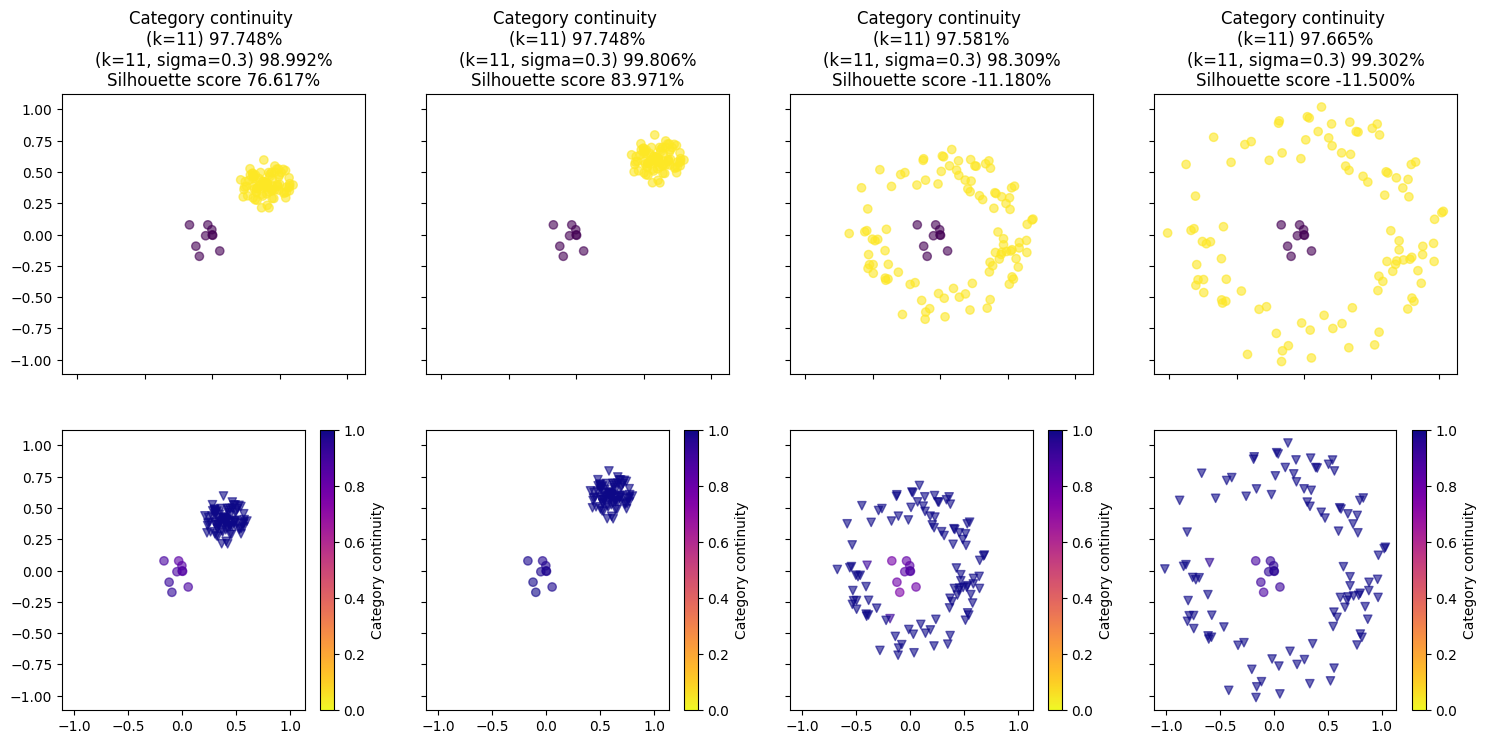

In [28]:
def ex_distances(sigma=0.3, d=1.5):
    """
    Plots to compare scores for cluster distance robustness.
    Arguments:
    ----------
    sigma: float
    distance parameter for category continuity score

    d: float
    Parameter to modify inter-cluster distance
    """
    # Generate
    N_in = 9
    X_in = generate_2D_ring_data(N_in, 0, 0.2)
    labels_in = np.array([0] * N_in)

    N_out = 100
    X_out_gaussian = generate_2D_ring_data(N_out, 0, 0.2)
    X_out1 = X_out_gaussian + 0.4
    X_out2 = X_out_gaussian + 0.4 * d
    X_out_ring = generate_2D_ring_data(N_out, 0.4, 0.7)
    X_out3 = X_out_ring
    X_out4 = X_out_ring * d
    labels_out = np.array([1] * N_out)

    fig, axs = plt.subplots(2, 4, figsize = (4 * 4 + 2, 4 * 2), sharex = True, sharey = True)
    for j, X_out in enumerate([X_out1, X_out2, X_out3, X_out4]):
        X = np.concatenate([X_in, X_out])
        y = np.concatenate([labels_in, labels_out])

        #Scores
        args_no_dist = {'k': N_in + 2, 'aggregation': 'total_mean', 'sigma' : None}
        s_no_dist, x_score = category_continuity(X, y, **args_no_dist)
        args_dist = {'k': N_in + 2, 'aggregation': 'total_mean', 'sigma' : 0.3}
        s_dist, x_score = category_continuity(X, y, **args_dist)
        s_ss = silhouette_score(X, y, metric="euclidean")

        # Plot
        axs[0, j].scatter(X[:, 0], X[:, 1], c=y, alpha = 0.6)
        axs[0, j].set_title(f"Category continuity \n(k={args_no_dist['k']}) {s_no_dist:.3%}\n(k={args_dist['k']}, sigma={args_dist['sigma']}) {s_dist:.3%}\nSilhouette score {s_ss:.3%}")
        plot_x_score(axs[1, j], X, y, x_score, score_label="Category continuity")

    plt.show()
if is_interactive:
    interact(ex_distances, sigma=(0.1, 1.5, 0.1), d=(1., 3.5, 0.1))
else:
    ex_distances(sigma = 0.3, d = 1.5)


>**4. Outliers are penalized proportionally to their number because they participate with a weight of 1. to the final score.**

The experiment below illustrates the decreasing of scores when the number of outliers is increasing. Category continuity and category score penalize outliers with the same trend.

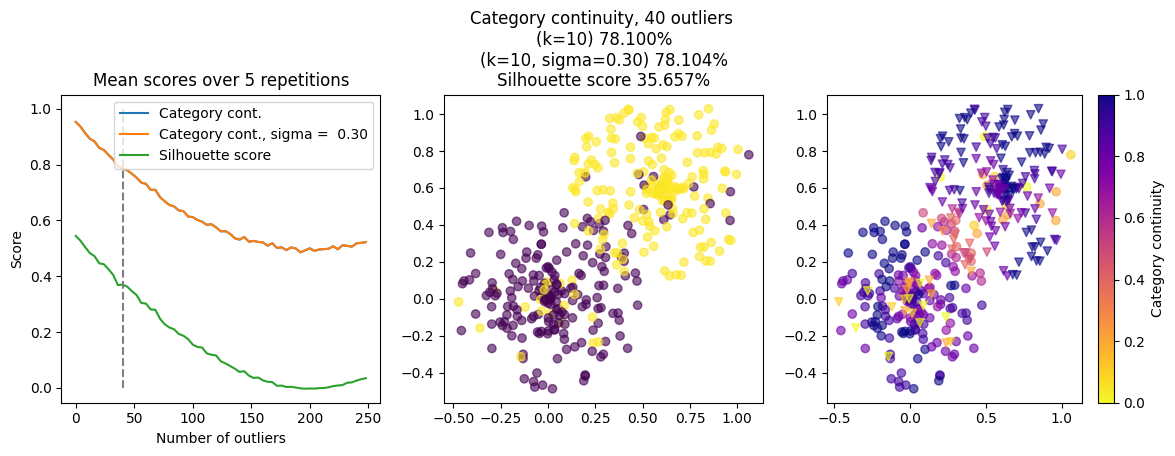

In [29]:
def ex_outliers(n_outlier_list, n_outliers_by_class=1, k = 10, N = 200, sigma=0.3):
    """
    Generate a graph of scores depending of outliers and plot a given experiment.
    """
    assert n_outliers_by_class <= N, "Please provide a number of outliers by class lower than N."
    fig, axs = plt.subplots(1, 3, figsize = (4 * 3 + 2, 4))

    # Generate
    X_l = generate_2D_ring_data(N, 0, 0.5)
    labels_l = np.array([0] * N)
    X_r = generate_2D_ring_data(N, 0, 0.5) + 0.6
    labels_r = np.array([1] * N)

    Nrep = 5
    s_nd_list = []
    s_d_list = []
    s_ss_list = []
    for n_outlier in n_outlier_list:
        s_nd_list_rep = []
        s_d_list_rep = []
        s_ss_list_rep = []
        for rep in range(Nrep):
            noise_ind = np.random.choice([i for i in range(N)], size=n_outlier, replace=False)
            labels_l_noisy = np.array(labels_l)
            labels_l_noisy[noise_ind] = 1
            labels_r_noisy = np.array(labels_r)
            labels_r_noisy[noise_ind] = 0
            X = np.concatenate([X_l, X_r])
            y = np.concatenate([labels_l_noisy, labels_r_noisy])

            #Scores
            args_no_dist = {'k': k, 'aggregation': 'total_mean', 'sigma' : None}
            s_no_dist, x_score = category_continuity(X, y, **args_no_dist)
            s_nd_list_rep.append(s_no_dist)
            args_dist = {'k': k, 'aggregation': 'total_mean', 'sigma' : sigma}
            s_dist, x_score = category_continuity(X, y, **args_dist)
            s_d_list_rep.append(s_dist)
            s_ss = silhouette_score(X, y, metric="euclidean")
            s_ss_list_rep.append(s_ss)
        s_nd_list.append(np.mean(s_nd_list_rep))
        s_d_list.append(np.mean(s_d_list_rep))
        s_ss_list.append(np.mean(s_ss_list_rep))

        # Plot
        if n_outlier == n_outliers_by_class:
            axs[1].scatter(X[:, 0], X[:, 1], c=y, alpha = 0.6)
            axs[1].set_title(f"Category continuity, {2*n_outliers_by_class} outliers \n(k={args_no_dist['k']}) {s_no_dist:.3%}\n(k={args_dist['k']}, sigma={args_dist['sigma']:.2f}) {s_dist:.3%}\nSilhouette score {s_ss:.3%}")
            plot_x_score(axs[2], X, y, x_score, score_label="Category continuity")

    axs[0].plot(np.array(n_outlier_list) * 2, s_nd_list, label="Category cont.")
    axs[0].plot(np.array(n_outlier_list) * 2, s_d_list, label=f"Category cont., sigma =  {sigma:.2f}")
    axs[0].plot(np.array(n_outlier_list) * 2, s_ss_list, label=f"Silhouette score")
    axs[0].plot([n_outliers_by_class*2] * 2, [0, 1], '--', color="grey")
    axs[0].legend(loc="upper right")
    axs[0].set_xlabel("Number of outliers")
    axs[0].set_ylabel("Score")
    axs[0].set_title(f"Mean scores over {Nrep} repetitions")
    plt.show()


n_outlier_list = [i for i in range(0, 125, 2)]
if is_interactive:
    interact(ex_outliers, n_outlier_list=fixed(n_outlier_list), k = (1, 200), N=(100, 500), sigma=(0.1, 1.5, 0.1), n_outliers_by_class=(0, 125, 2))
else:
    ex_outliers(n_outlier_list, 20)

## Playground

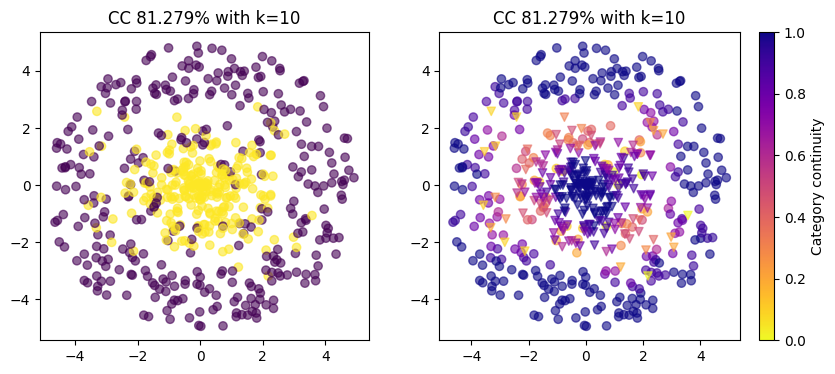

In [33]:
def get_circular(N, radius_min, radius_max):
    rs = np.random.rand(N) * (radius_max - radius_min) + radius_min
    angles = np.random.rand(N) * 2 * np.pi
    return np.vstack([rs * np.cos(angles), rs * np.sin(angles)]).T

def ex_circular_separable(k=3, N = 300, noise_level = 0., separation = 0.2):
    radius = 5
    r_sep = radius * (0.5 + separation / 2)
    X_in = get_circular(N, 0, radius * 0.5)
    X_in_noisy = X_in + (np.random.rand(N, 2) * 2 * r_sep - r_sep) * noise_level
    y_in = 1. * (np.linalg.norm(X_in_noisy, axis = 1) < radius * 0.5)

    X_out = get_circular(N, radius * (0.5 + separation), radius)
    X_out_noisy = X_out + (np.random.rand(N, 2) * 2 * r_sep - r_sep) * noise_level
    y_out = 1. * (np.linalg.norm(X_out_noisy, axis = 1) < radius * 0.5)

    X = np.concatenate((X_in, X_out))
    y = np.concatenate((y_in, y_out))
    args = {'k': k, 'aggregation': 'total_mean', 'sigma' : 1.}
    s, x_scores = category_continuity(X, y, **args)

    fig, axs = plt.subplots(1, 2, figsize = (2 + 4 * 2, 4), width_ratios=[3.5, 4])
    cmap_score = cm.plasma_r
    marker = {0: 'o', 1: 'v'}
    axs[0].scatter(X[:, 0], X[:, 1], c=y, alpha = 0.6)
    axs[0].set_title(f"CC {s:.3%} with k={args['k']}")
    plot_x_score(axs[1], X, y, x_scores, score_label="Category continuity")
    axs[1].set_title(f"CC {s:.3%} with k={args['k']}")

    plt.show()

if is_interactive:
    interact(ex_circular_separable, k=(1, 499), N = (1, 500), noise_level = (0., 1., 0.05), separation = (0., 0.5, 0.1))
else:
    ex_circular_separable(k = 10, N = 300, noise_level=0.5, separation = 0.1)


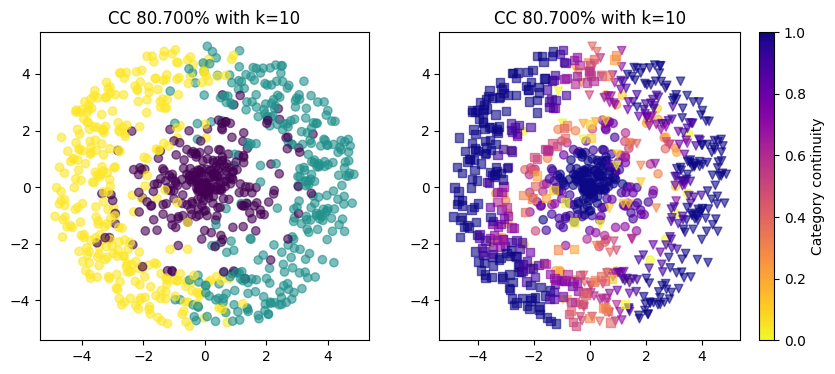

In [34]:
def ex_circular_separable_3(k=3, N = 300, noise_level = 0., separation = 0.2):
    radius = 5
    r_sep = radius * (0.5 + separation / 2)
    X_in = get_circular(N, 0, radius * 0.5)
    X_in_noisy = X_in + (np.random.rand(N, 2) * 2 * r_sep - r_sep) * noise_level
    y_in = 1. * (np.linalg.norm(X_in_noisy, axis = 1) > radius * 0.5)
    y_in = y_in + y_in * (X_in_noisy[:, 0] < 0.)

    X_out = get_circular(2 * N, radius * (0.5 + separation), radius)
    X_out_noisy = X_out + (np.random.rand(2 * N, 2) * 2 * r_sep - r_sep) * noise_level
    y_out = 1. * (np.linalg.norm(X_out_noisy, axis = 1) > radius * 0.5)
    y_out = y_out + y_out * (X_out_noisy[:, 0] < 0.)

    X = np.concatenate((X_in, X_out))
    y = np.concatenate((y_in, y_out))
    args = {'k': k, 'aggregation': 'total_mean', 'sigma' : None}
    s, x_scores = category_continuity(X, y, **args)

    fig, axs = plt.subplots(1, 2, figsize = (2 + 4 * 2, 4), width_ratios=[3.5, 4])
    cmap_score = cm.plasma_r
    marker = {0: 'o', 1: 'v'}
    axs[0].scatter(X[:, 0], X[:, 1], c=y, alpha = 0.6)
    axs[0].set_title(f"CC {s:.3%} with k={args['k']}")
    plot_x_score(axs[1], X, y, x_scores, score_label="Category continuity")
    axs[1].set_title(f"CC {s:.3%} with k={args['k']}")

    plt.show()

if is_interactive:
    interact(ex_circular_separable_3, k=(1, 499), N = (1, 500), noise_level = (0., 1., 0.05), separation = (0., 0.5, 0.1))
else:
    ex_circular_separable_3(k = 10, N = 300, noise_level=0.5, separation = 0.1)

